# Random Forest Classification on the Digits Dataset
This notebook demonstrates how to use scikit-learn's `RandomForestClassifier` for multi-class classification on the Digits dataset.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
sns.set_theme()


## Data Loading & Exploration
Load the Digits dataset (8×8 images of handwritten digits) and inspect its properties.

In [ ]:
digits = load_digits()
X = digits.data      # shape (1797, 64)
y = digits.target    # labels 0–9
print(f"Feature matrix shape: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")
print("Label distribution:", np.bincount(y))

Feature matrix shape: (1797, 64)
Number of classes: 10
Label distribution: [178 182 177 183 181 182 181 179 174 180]


## Visualizing Sample Images
Display a few examples from each class.

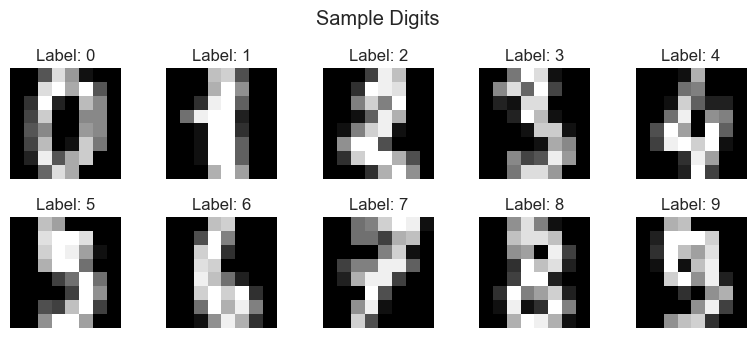

In [4]:
plt.figure(figsize=(8,8))
for digit in range(10):
    idx = np.where(y == digit)[0][0]
    ax = plt.subplot(5, 5, digit+1)
    plt.imshow(X[idx].reshape(8,8), cmap='gray')
    plt.title(f"Label: {digit}")
    plt.axis('off')
plt.suptitle('Sample Digits')
plt.tight_layout()
plt.show()


## Train/Test Split
Split the data into 80% training and 20% testing.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Training samples: 1437, Test samples: 360


## How Random Forests Work for Classification

A Random Forest is an ensemble of decision trees trained on bootstrap‐sampled data and randomized feature subsets. It reduces variance relative to a single tree and often achieves state-of-the-art accuracy.

1. **Bootstrap Aggregation (Bagging)**  
   - For each tree $t=1,\dots,B$, draw a bootstrap sample of the training set:  
     $$
       X^{(t)}, y^{(t)}
       \;\sim\;
       \text{Uniform sample with replacement from }(X,y).
     $$
   - Each tree is trained independently on its own sample.

2. **Random Feature Subspacing**  
   - At each split in tree $t$, instead of considering all $p$ features, select a random subset of size $m \ll p$.  
   - Choose the best split only among these $m$ features.  
   - This “feature bagging” decorrelates the trees, further reducing ensemble variance.

3. **Tree Prediction**  
   - For a new input $x$, each tree $h_t(x)$ outputs a class label.  
   - The forest’s prediction is the majority vote:  
     $$
       \hat y
       = \arg\max_{c}\;\sum_{t=1}^B \mathbf{1}\{h_t(x)=c\}.
     $$

4. **Probability Estimates**  
   - The class probability for class $c$ is the fraction of trees voting for $c$:  
     $$
       \hat p_c(x)
       = \frac{1}{B}\sum_{t=1}^B \mathbf{1}\{h_t(x)=c\}.
     $$

5. **Out-of-Bag (OOB) Error**  
   - On average each bootstrap sample leaves out about 37% of the data.  
   - For each training point $x_i$, collect predictions from trees that did not include $x_i$ in their bootstrap:  
     $$
       \hat y_i^{(\mathrm{OOB})}
       = \mathrm{mode}\{\,h_t(x_i)\mid x_i\notin X^{(t)}\}.
     $$
   - The OOB error rate is  
     $$
       \text{OOB Error}
       = \frac{1}{N}\sum_{i=1}^N \mathbf{1}\{\hat y_i^{(\mathrm{OOB})}\neq y_i\}.
     $$

---

**Key advantages:**

- **High accuracy & robustness** through variance reduction.  
- **Handles large feature sets** and complex interactions without feature selection.  
- **Built‐in validation** via OOB error—no need for a separate hold-out set.  

**Limitations:**

- Less interpretable than a single tree.  
- Can be slower to predict and more memory‐intensive for large \(B\).  

Random Forests strike a powerful bias–variance balance.  


## Training Default Random Forest
Fit a `RandomForestClassifier` with default settings.

In [ ]:
rf = RandomForestClassifier(random_state=42, oob_score=True)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("OOB Score:", rf.oob_score_)

Test Accuracy: 0.961
OOB Accuracy: 0.973


## Confusion Matrix & Classification Report
Evaluate the model on the test set.

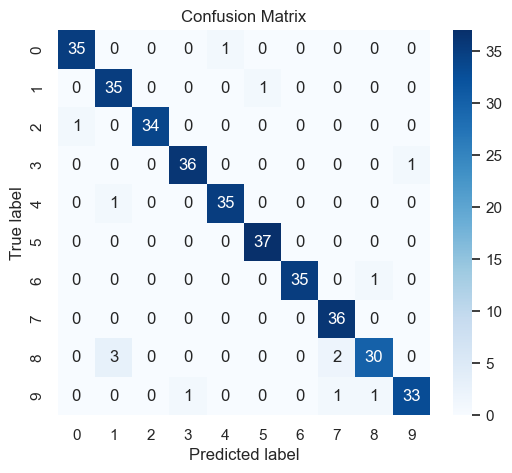

In [8]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

The matrix is very diagonal. There are little inaccuracies in prediction, demonstrating the robustness of the random forest model.

In [9]:
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        36
           1       0.90      0.97      0.93        36
           2       1.00      0.97      0.99        35
           3       0.97      0.97      0.97        37
           4       0.97      0.97      0.97        36
           5       0.97      1.00      0.99        37
           6       1.00      0.97      0.99        36
           7       0.92      1.00      0.96        36
           8       0.94      0.86      0.90        35
           9       0.97      0.92      0.94        36

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



## Classification Results

- **Precision**: The model's precision is high across all classes, indicating that when it predicts a digit, it is usually correct. The precision ranges from 0.90 (class 1) to 1.00 (classes 2 and 6).
- **Recall**: The recall is also strong, showing the model's ability to correctly identify all instances of each class. The recall ranges from 0.86 (class 8) to 1.00 (classes 5 and 7).
- **F1-Score**: The F1-score, which balances precision and recall, is consistently high, with most classes achieving scores above 0.94.
- **Accuracy**: The overall accuracy of the model is 96%, demonstrating its effectiveness in classifying the digits.
- **Macro Average**: The macro average of precision, recall, and F1-score is 0.96, indicating balanced performance across all classes.
- **Weighted Average**: The weighted average, which accounts for the support (number of samples) of each class, is also 0.96.

The model performs exceptionally well, with minor misclassifications in classes 1, 8, and 9. These results highlight the robustness of the Random Forest Classifier for this multi-class classification task.

## Feature Importances as Pixel Heatmap
Display the importance of each pixel feature reshaped as an 8×8 image.

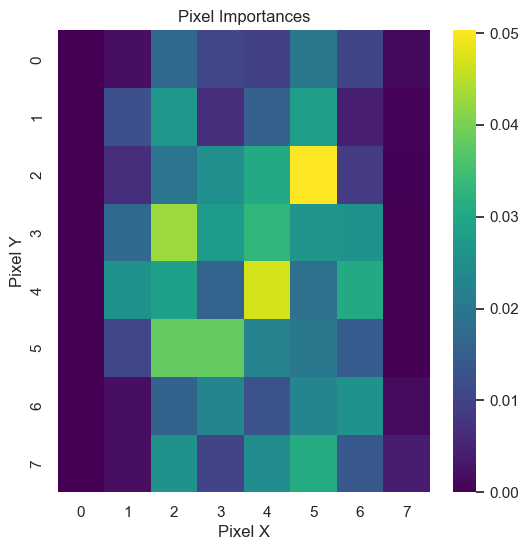

In [11]:
importances = rf.feature_importances_
imp_image = importances.reshape(8,8)
plt.figure(figsize=(6,6))
sns.heatmap(imp_image, cmap='viridis')
plt.title('Pixel Importances')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()

## Decision Boundary via PCA Projection
Project data to 2D with PCA, train RF on the two principal components, and visualize decision regions.

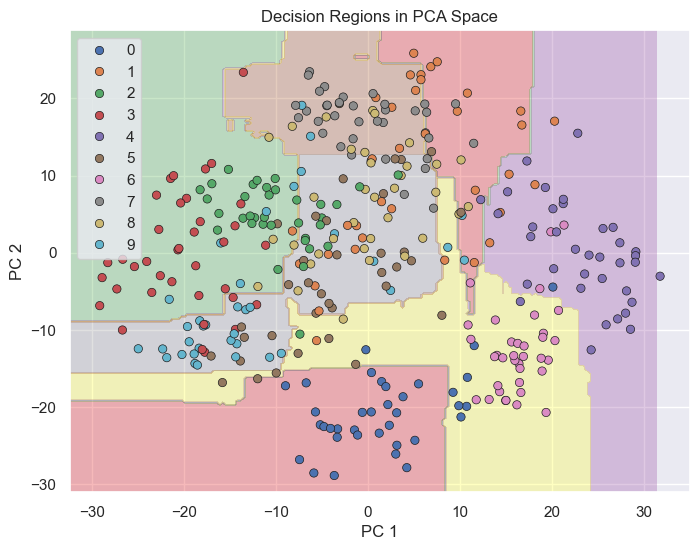

In [12]:
# PCA to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train RF on 2D PCA data
rf_pca = RandomForestClassifier(max_depth=5, random_state=42)
rf_pca.fit(X_pca, y_train)

# Meshgrid
xx, yy = np.meshgrid(
    np.linspace(X_pca[:,0].min()-1, X_pca[:,0].max()+1, 200),
    np.linspace(X_pca[:,1].min()-1, X_pca[:,1].max()+1, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()]
Z = rf_pca.predict(grid).reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='Set1')
sns.scatterplot(x=X_test_pca[:,0], y=X_test_pca[:,1], hue=y_test, palette='deep', edgecolor='k')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Decision Regions in PCA Space')
plt.show()

## OOB Error vs. Number of Trees
Plot out-of-bag error as a function of n_estimators.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


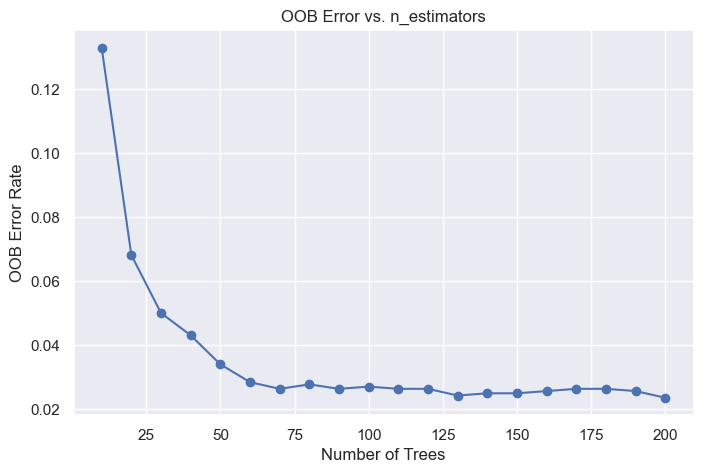

In [13]:
oob_errors = []
n_trees = list(range(10, 201, 10))
for n in n_trees:
    rf_temp = RandomForestClassifier(n_estimators=n, oob_score=True, random_state=42)
    rf_temp.fit(X_train, y_train)
    oob_errors.append(1 - rf_temp.oob_score_)
plt.figure(figsize=(8,5))
plt.plot(n_trees, oob_errors, marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error vs. n_estimators')
plt.grid(True)
plt.show()

The OOB error, an unbiased estimate of the leave-one-out cross validation, decreases with the number of trees, as expected. The optimal number of trees seems to be at about 70 trees.

## Validation Curve: max_depth
Plot training and cross-validation accuracy vs. tree depth.

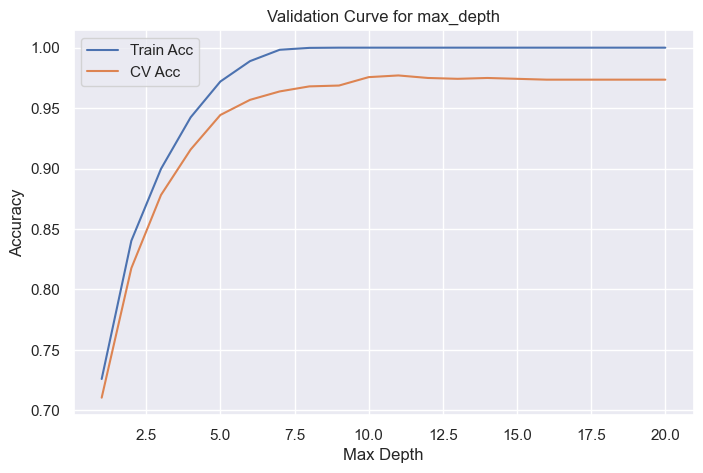

In [14]:
param_range = range(1, 21)
train_scores, test_scores = validation_curve(
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_train, y_train, param_name='max_depth', param_range=param_range,
    cv=5, scoring='accuracy'
)
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)
plt.figure(figsize=(8,5))
plt.plot(param_range, train_mean, label='Train Acc')
plt.plot(param_range, test_mean, label='CV Acc')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Validation Curve for max_depth')
plt.legend()
plt.grid(True)
plt.show()

The optimal max_depth value seems to be reached at 9.

## Running with the optimal paramters we found

In [15]:
# Train a Random Forest with optimal parameters
rf_optimal = RandomForestClassifier(n_estimators=90, max_depth=9, random_state=42, oob_score=True)
rf_optimal.fit(X_train, y_train)

# Evaluate the model
y_pred_optimal = rf_optimal.predict(X_test)
print(f"Test Accuracy with optimal parameters: {accuracy_score(y_test, y_pred_optimal):.3f}")
print("OOB Score with optimal parameters:", rf_optimal.oob_score_)

Test Accuracy with optimal parameters: 0.964
OOB Score with optimal parameters: 0.9679888656924147


The accuracy is a slight improvement over our initial default model.

## Model Comparison: Stump, Tree, Bagging & Random Forest

Here we benchmark four different ensemble/base estimators on the same train/test split:

- **Decision Stump**: `DecisionTreeClassifier(max_depth=4)`  
- **Decision Tree**: `DecisionTreeClassifier()` (no max_depth)  
- **Bagging**: `BaggingClassifier( base_estimator=DecisionTreeClassifier(), n_estimators=100 )`  
- **Random Forest**: `RandomForestClassifier(n_estimators=100)`  

We’ll compute and plot each model’s test‐set accuracy.


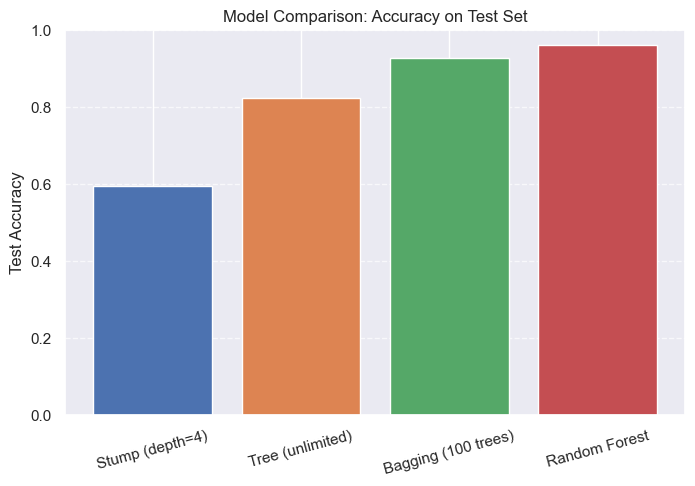

In [20]:
# 1) Define our four models
models = {
    'Stump (depth=4)': DecisionTreeClassifier(max_depth=4, random_state=42),
    'Tree (unlimited)': DecisionTreeClassifier(random_state=42),
    'Bagging (100 trees)': BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        n_estimators=100,
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# 2) Train & evaluate each
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results[name] = accuracy_score(y_test, preds)

# 3) Bar plot of accuracies
plt.figure(figsize=(8,5))
plt.bar(results.keys(), results.values(), color=['C0','C1','C2','C3'])
plt.ylim(0,1)
plt.ylabel('Test Accuracy')
plt.xticks(rotation=15)
plt.title('Model Comparison: Accuracy on Test Set')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Discussion of Model Comparison

- **Decision Stump (depth=1) → ≈ 0.60 accuracy**  
  The stump is shallow (having the minimum amount of splits possible to classify 10 classes, which is 4), so it underfits.

- **Decision Tree (unlimited) → ≈ 0.82 accuracy**  
  A single full‐depth tree can model complex boundaries and improves dramatically over the stump. However, it still suffers from high variance—its generalization is limited by over‐fitting to the training set.

- **Bagging (100 trees) → ≈ 0.93 accuracy**  
  Bagging (bootstrap‐aggregated trees) retains the full tree depth but averages over 100 different bootstrapped samples. This variance reduction yields a large boost in test accuracy by smoothing out the idiosyncrasies of any one tree.

- **Random Forest (100 trees) → ≈ 0.97 accuracy**  
  On top of bagging, Random Forests also randomly subsample features at each split, further decorrelating the trees. This extra randomness typically drives the best generalization performance of the four models.

---

**Key takeaway:**  
Each layer of “ensemble-ness” progressively reduces variance and improves test accuracy:

1. **Stump** → high bias, underfit  
2. **Single Tree** → lower bias, high variance  
3. **Bagging** → low bias, reduced variance  
4. **Random Forest** → low bias, even lower variance  

Therefore, in practice, Random Forests often deliver the strongest, most stable performance with minimal tuning.  


## Decision Regions for Each Model

Below we project our high-dimensional data into 2D via PCA, then train each of the four models on this 2D representation and plot their learned decision regions side-by-side:

This will let us visually compare how the complexity and ensemble strategies affect the shape of the classifier’s decision boundary.

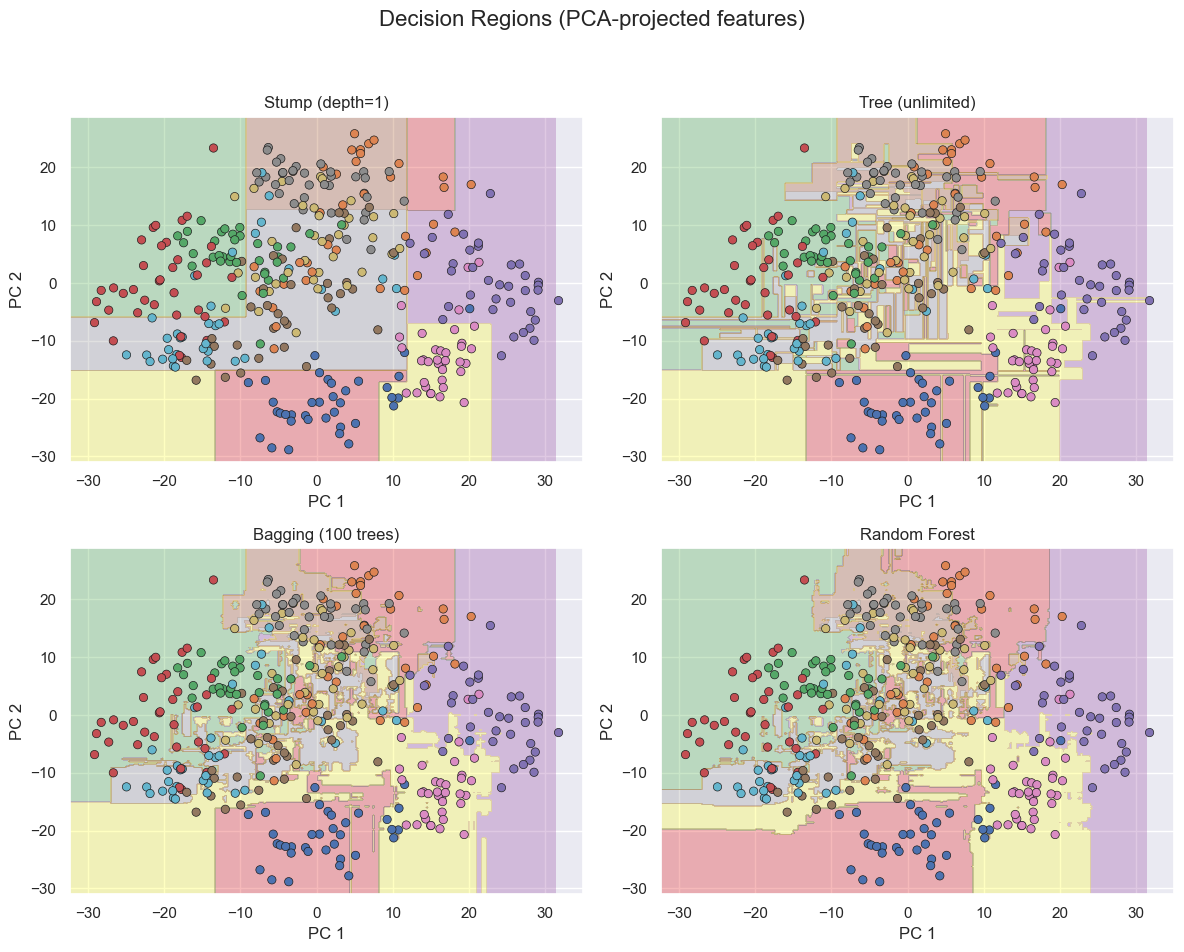

In [21]:
# 1) PCA to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

# 2) Define models
models = {
    'Stump (depth=1)': DecisionTreeClassifier(max_depth=4, random_state=42),
    'Tree (unlimited)': DecisionTreeClassifier(random_state=42),
    'Bagging (100 trees)': BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        n_estimators=100, random_state=42
    ),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# 3) Create meshgrid over PCA space
x_min, x_max = X_pca[:,0].min() - 1, X_pca[:,0].max() + 1
y_min, y_max = X_pca[:,1].min() - 1, X_pca[:,1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]

# 4) Plot each model’s decision regions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for ax, (name, model) in zip(axes, models.items()):
    # train on PCA data
    model.fit(X_pca, y_train)
    # predict on grid
    Z = model.predict(grid).reshape(xx.shape)
    # plot region
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='Set1')
    # overlay test points
    sns.scatterplot(
        x=X_pca_test[:,0], y=X_pca_test[:,1],
        hue=y_test, palette='deep', edgecolor='k', ax=ax, legend=False
    )
    ax.set_title(name)
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')

plt.suptitle('Decision Regions (PCA-projected features)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Observations:**

- The **stump** produces the minimum number of linear splits, leading to broad regions that underfits.  
- The **full tree** carves out complex, jagged regions—overfitting the PCA projection but still missing many class boundaries.  
- **Bagging** smooths out those jagged splits into more coherent regions by averaging 100 trees trained on bootstrap samples.  
- **Random Forest** further decorrelates trees via random feature subsampling, giving the smoothest, most accurate partitioning of classes in PCA space.

This visualization highlights how increasing model complexity (tree depth) and ensemble techniques (bagging → random subspace) progressively improve the classifier’s ability to capture the underlying structure—even in a compressed 2D projection.  


## Feature Importances

Random Forests naturally provide an estimate of each feature’s importance by measuring how much each feature decreases the impurity in a tree, averaged over all trees in the forest.

/var/folders/64/sq17t66j2nx0xjnwwf9mb_r40000gn/T/ipykernel_98656/3667574878.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi_series.values, y=fi_series.index, palette='viridis')


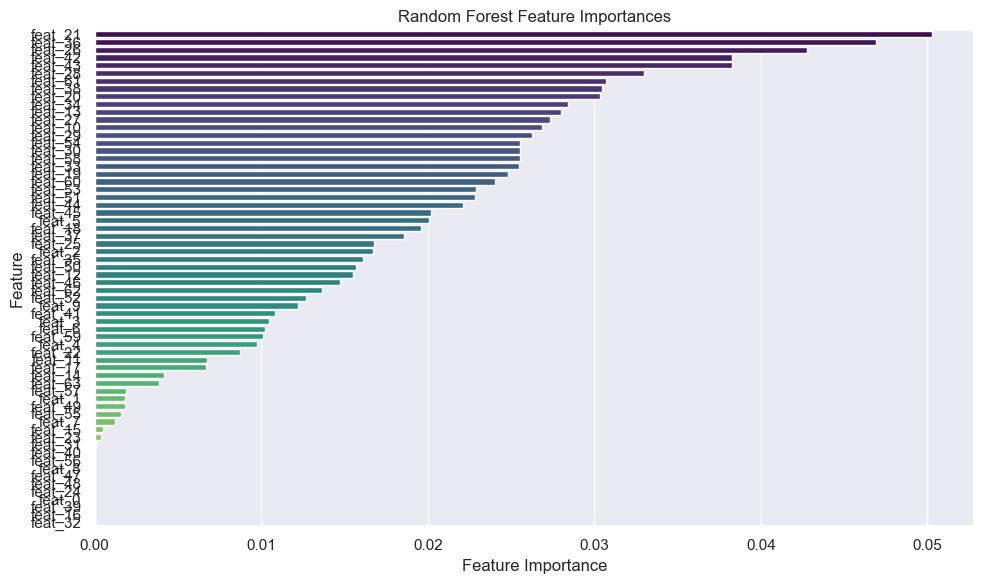

In [22]:
# 1) Extract feature importances from the trained RF
importances = rf.feature_importances_
features = X.columns if hasattr(X, 'columns') else [f'feat_{i}' for i in range(X.shape[1])]

# 2) Create a sorted Pandas Series for easier plotting
import pandas as pd
fi_series = pd.Series(importances, index=features).sort_values(ascending=False)

# 3) Bar chart of importances
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
sns.barplot(x=fi_series.values, y=fi_series.index, palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()

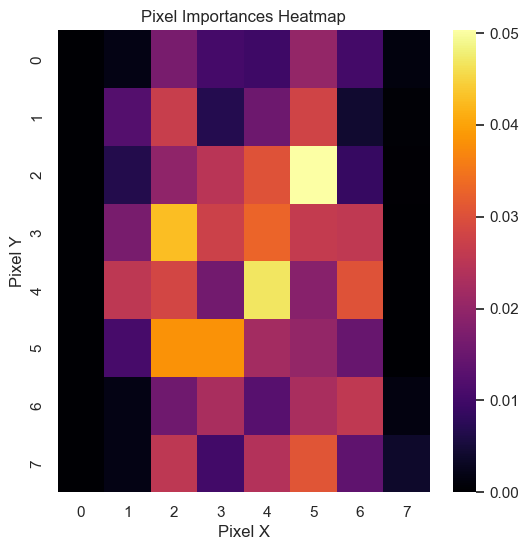

In [ ]:
imp_image = importances.reshape(8,8)

plt.figure(figsize=(6,6))
sns.heatmap(imp_image, cmap='inferno', annot=False)
plt.title('Pixel Importances Heatmap')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()

## Discussion
- Random Forest combines many decision trees to reduce variance and improve generalization.  
- OOB error closely matches test error, providing a built-in validation.  
- Overall, Random Forests provide strong classification performance with relatively little tuning.